In [3]:
x: int = 10
x 

10.0

In [1]:
import pandas as pd
import numpy as np
import config
from env import StockTradingEnv
from helper_function import check_and_make_directories
from models import DRLAgent
from stable_baselines3.common.logger import configure
import matplotlib.pyplot as plt

import os
import itertools
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from models import DRLAgent, DRLEnsembleAgent

c:\Users\enomazosii\miniconda3\envs\rltrade\Lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
check_and_make_directories([config.TRAINED_MODEL_DIR,
                            config.TENSORBOARD_LOG_DIR,
                            config.RESULTS_DIR])

In [3]:
train = pd.read_csv('data/train_data.csv') # 2009-01-02 to 2020-06-30

train = train.set_index(train.columns[0])
train.index.names = ['']
display(train)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.743889,746015200.0,4.0,0.000000,2.965560,2.638021,100.000000,66.666667,100.000000,2.743889,2.743889,39.189999,0.000000
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,42.406380,6547900.0,4.0,0.000000,2.965560,2.638021,100.000000,66.666667,100.000000,42.406380,42.406380,39.189999,0.000000
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.098143,10955700.0,4.0,0.000000,2.965560,2.638021,100.000000,66.666667,100.000000,15.098143,15.098143,39.189999,0.000000
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941109,7010200.0,4.0,0.000000,2.965560,2.638021,100.000000,66.666667,100.000000,33.941109,33.941109,39.189999,0.000000
0,2009-01-02,CAT,44.910000,46.980000,44.709999,30.950010,7117200.0,4.0,0.000000,2.965560,2.638021,100.000000,66.666667,100.000000,30.950010,30.950010,39.189999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,279.649536,2932900.0,1.0,-0.018924,295.342546,263.590737,52.413041,-26.061887,1.802109,279.886563,273.065547,30.430000,12.918872
2892,2020-06-30,V,191.490005,193.750000,190.160004,188.127823,9040100.0,1.0,1.034439,196.031514,182.509933,53.021020,-51.683677,3.333755,188.865415,179.192232,30.430000,12.918872
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,44.822735,17414800.0,1.0,-0.388919,47.973946,43.356943,48.097039,-51.451321,6.514530,45.388064,45.790726,30.430000,12.918872


In [4]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [5]:

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 10000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

In [6]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
    tmp_path = config.RESULTS_DIR + '/a2c'
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [7]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c',total_timesteps=1000000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 62          |
|    iterations         | 100         |
|    time_elapsed       | 8           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | 0.447       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -9.44       |
|    reward             | -0.10822373 |
|    std                | 1           |
|    value_loss         | 0.0766      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 75          |
|    iterations         | 200         |
|    time_elapsed       | 13          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -41.4       |
|    explained_variance | 0.255       |


ValueError: Expected parameter scale (Tensor of shape (1, 29)) of distribution Normal(loc: torch.Size([1, 29]), scale: torch.Size([1, 29])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[       nan, 4.1659e+18, 4.1045e+18, 3.3689e+18, 3.7400e+18, 2.9112e+18,
         2.7592e+18, 3.1748e+18, 4.2155e+18, 3.7375e+18, 2.5572e+18, 2.7258e+18,
         2.7860e+18, 3.9233e+18, 2.8655e+18, 2.8020e+18, 3.1212e+18, 2.3908e+18,
         3.8255e+18, 3.1431e+18, 2.5466e+18, 4.5656e+18, 4.8230e+18, 3.4171e+18,
         2.5781e+18, 3.7552e+18, 2.3659e+18, 3.5194e+18, 4.0348e+18]],
       device='cuda:0')

In [8]:
trained_a2c.save(config.TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

NameError: name 'trained_a2c' is not defined

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
    # set up logger
    tmp_path = config.RESULTS_DIR + '/ddpg'
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001, 'tau': 0.001, 'gamma': 0.99}
Using cuda device
Logging to results/ddpg


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                                tb_log_name='ddpg',
                                total_timesteps=100000) if if_using_ddpg else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 72        |
|    time_elapsed    | 160       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -4.77e+03 |
|    critic_loss     | 6.8e+04   |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 20.423101 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 67        |
|    time_elapsed    | 344       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | -3.16e+03 |
|    critic_loss     | 1.03e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 20251     |
|    reward          | 20.423101 |
----------------------------------
day: 2892, episode: 360
begin_total_asset: 10000000.00
end_total_asset: 38361272.59
total_

In [ ]:
trained_ddpg.save(config.TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None 

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 256,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
    # set up logger
    tmp_path = config.RESULTS_DIR + '/ppo'
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 256}
Using cuda device


AssertionError: tensorboard is not installed, you can use `pip install tensorboard` to do so

In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                                tb_log_name='ppo',
                                total_timesteps=200000) if if_using_ppo else None

KeyboardInterrupt: 

In [ ]:
trained_ppo.save(config.TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size":200,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
    # set up logger
    tmp_path = config.RESULTS_DIR + '/td3'
    new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_td3.set_logger(new_logger_td3)

{'batch_size': 200, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                                tb_log_name='td3',
                                total_timesteps=200000) if if_using_td3 else None

day: 2892, episode: 460
begin_total_asset: 10000000.00
end_total_asset: 48516633.69
total_reward: 38516633.69
total_cost: 11799.47
total_trades: 35952
Sharpe: 0.851
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 71       |
|    time_elapsed    | 162      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 2.52e+03 |
|    critic_loss     | 4.77e+04 |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 65.6913  |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 65       |
|    time_elapsed    | 351      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 1.62e+03 |
|    critic_loss     | 8.15e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 20251    |
|    reward        

In [ ]:
trained_td3.save(config.TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 512,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
    # set up logger
    tmp_path = config.RESULTS_DIR + '/sac'
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_sac.set_logger(new_logger_sac)

{'batch_size': 512, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                                tb_log_name='sac',
                                total_timesteps=50000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 34        |
|    time_elapsed    | 339       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 6.61e+03  |
|    critic_loss     | 6.31e+03  |
|    ent_coef        | 0.305     |
|    ent_coef_loss   | 433       |
|    learning_rate   | 0.0001    |
|    n_updates       | 11471     |
|    reward          | 21.670313 |
----------------------------------
day: 2892, episode: 580
begin_total_asset: 10000000.00
end_total_asset: 46491550.52
total_reward: 36491550.52
total_cost: 9990.01
total_trades: 36965
Sharpe: 0.804
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 34        |
|    time_elapsed    | 673       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 1.47e+04  |
|    critic_loss     | 2.2e+05 

In [ ]:
trained_sac.save(config.TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

---

# Backtesting

In [ ]:
import pandas as pd
import numpy as np
import os
import itertools

from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from env import StockTradingEnv
from helper_function import check_and_make_directories
from models import DRLAgent, DRLEnsembleAgent
from stable_baselines3.common.logger import configure
import config

import matplotlib.pyplot as plt


%matplotlib inline

In [ ]:
train = pd.read_csv('./data/train_data.csv')
trade = pd.read_csv('./data/trade_data.csv')
backtest = pd.read_csv('./data/backtest_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']
backtest = backtest.set_index(backtest.columns[0])
backtest.index.names = ['']

In [ ]:
train.shape, trade.shape, backtest.shape #((83897, 18), (9744, 18), (1218, 18))

((83897, 18), (9744, 18), (1218, 18))

In [ ]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [ ]:
trained_a2c = A2C.load(config.TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(config.TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(config.TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(config.TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(config.TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

In [ ]:
stock_dimension = len(train.tic.unique())
state_space =  2 * stock_dimension + len(config.INDICATORS) * stock_dimension + 1
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
stock_dimension = len(trade.tic.unique())
state_space =  2 * stock_dimension + len(config.INDICATORS) * stock_dimension + 1
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [45]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [46]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [47]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [48]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


In [49]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
        "sac": df_result_sac["account_value"] if if_using_sac else None,
    }
)

result

,a2c,ddpg,ppo,td3,sac
date,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2020-07-02,1.000605e+06,1.000505e+06,9.999845e+05,1.000616e+06,1.000692e+06
2020-07-06,1.004745e+06,1.007153e+06,1.001484e+06,1.006339e+06,1.004316e+06
2020-07-07,9.973455e+05,9.971031e+05,9.998880e+05,9.971507e+05,9.946596e+05
2020-07-08,1.000388e+06,1.002498e+06,1.001162e+06,1.001873e+06,9.967409e+05
...,...,...,...,...,...
2021-10-21,1.377686e+06,1.432363e+06,1.339935e+06,1.450914e+06,1.357916e+06
2021-10-22,1.385633e+06,1.435234e+06,1.348031e+06,1.454722e+06,1.364988e+06
2021-10-25,1.386418e+06,1.441563e+06,1.349106e+06,1.453191e+06,1.368827e+06


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

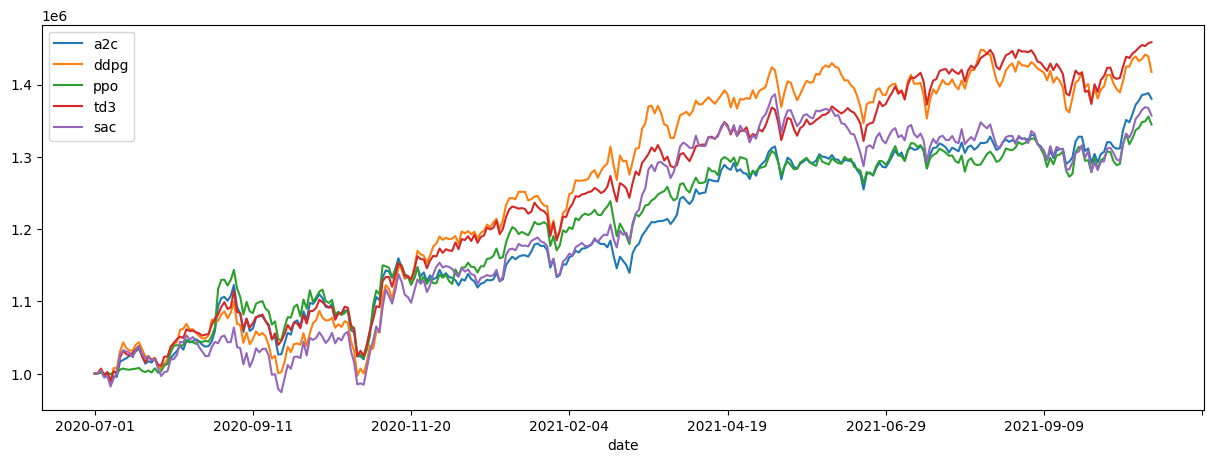

In [50]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

# Ensemble

In [68]:
data = pd.concat([train, trade], axis=0)
data

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.743889,746015200.0,4.0,0.000000,2.965561,2.638020,100.000000,66.666667,100.000000,2.743889,2.743889,39.189999,0.000000
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,42.406384,6547900.0,4.0,0.000000,2.965561,2.638020,100.000000,66.666667,100.000000,42.406384,42.406384,39.189999,0.000000
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.144917,10955700.0,4.0,0.000000,2.965561,2.638020,100.000000,66.666667,100.000000,15.144917,15.144917,39.189999,0.000000
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941105,7010200.0,4.0,0.000000,2.965561,2.638020,100.000000,66.666667,100.000000,33.941105,33.941105,39.189999,0.000000
0,2009-01-02,CAT,44.910000,46.980000,44.709999,30.950016,7117200.0,4.0,0.000000,2.965561,2.638020,100.000000,66.666667,100.000000,30.950016,30.950016,39.189999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2021-10-27,UNH,454.640015,460.440002,453.480011,437.944458,3520400.0,2.0,11.262194,448.257368,359.524569,65.085958,174.381470,30.848035,400.928238,401.210696,16.980000,145.430579
334,2021-10-27,V,224.750000,224.750000,215.660004,211.704575,22958100.0,2.0,0.013774,232.560551,214.422810,41.737199,-153.656516,23.662740,222.603772,224.808517,16.980000,145.430579
334,2021-10-27,VZ,53.169998,53.200001,52.470001,45.713467,15007400.0,2.0,-0.212331,47.395247,44.442474,44.604906,-49.992631,13.530363,46.145385,46.739158,16.980000,145.430579


In [69]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [70]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=data,
                                  train_period=(config.TRAIN_START_DATE,config.TRAIN_END_DATE),
                                  val_test_period=(config.TEST_START_DATE,config.TEST_END_DATE),
                                  rebalance_window=rebalance_window, 
                                  validation_window=validation_window, 
                                  **env_kwargs)

In [73]:
timesteps_dict = {'a2c' : 10000, 
                  'ppo' : 10000, 
                  'ddpg' : 10000,
                  'sac' : 10000,
                  'td3' : 10000}

In [74]:
df_summary = ensemble_agent.run_ensemble_strategy(config.A2C_PARAMS,
                                                  config.PPO_PARAMS,
                                                  config.DDPG_PARAMS,
                                                  config.SAC_PARAMS,
                                                  config.TD3_PARAMS,
                                                  timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.7418446302624
======Model training from:  2009-01-01 to  2020-07-02
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c\a2c_126_2


c:\Users\rh987\miniconda3\envs\torchrl\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rh987\miniconda3\envs\torchrl\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------------------------------------
| time/                 |             |
|    fps                | 77          |
|    iterations         | 100         |
|    time_elapsed       | 6           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -2.49       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 33.6        |
|    reward             | -0.11425099 |
|    std                | 1           |
|    value_loss         | 0.913       |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 78         |
|    iterations         | 200        |
|    time_elapsed       | 12         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    lear

In [75]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2020-07-02,2020-10-01,TD3,0.138523,0.22561,0.207941,0.060592,0.314517
1,189,2020-10-01,2020-12-31,DDPG,0.263081,0.165124,0.334676,0.177278,0.30505
2,252,2020-12-31,2021-04-05,TD3,0.224953,0.308174,0.377381,0.249578,0.422257
3,315,2021-04-05,2021-07-02,A2C,0.285369,0.105275,0.278755,0.104472,0.222126


# Backtesting

In [6]:
import pandas as pd
import numpy as np
import config
from env import StockTradingEnv
from stable_baselines3.common.logger import configure
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

import os
import itertools

%matplotlib inline

In [7]:
train = pd.read_csv('./data/train_data.csv')
trade = pd.read_csv('./data/trade_data.csv')
backtest = pd.read_csv('./data/backtest_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']
backtest = backtest.set_index(backtest.columns[0])
backtest.index.names = ['']

In [8]:
unique_trade_date = trade.date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})
df_account_value=pd.DataFrame()
for i in range(config.REBALANCE_WINDOW+config.VALIDATION_WINDOW, len(unique_trade_date)+1,config.REBALANCE_WINDOW):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[config.VALIDATION_WINDOW:].reset_index(drop=True))

Sharpe Ratio:  1.129529642080717


In [9]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-10-01,NaN,2020-09-30
1,9.993548e+05,2020-10-02,-0.000645,2020-10-01
2,1.006246e+06,2020-10-05,0.006896,2020-10-02
3,9.949070e+05,2020-10-06,-0.011269,2020-10-05
4,1.013812e+06,2020-10-07,0.019002,2020-10-06


<Axes: >

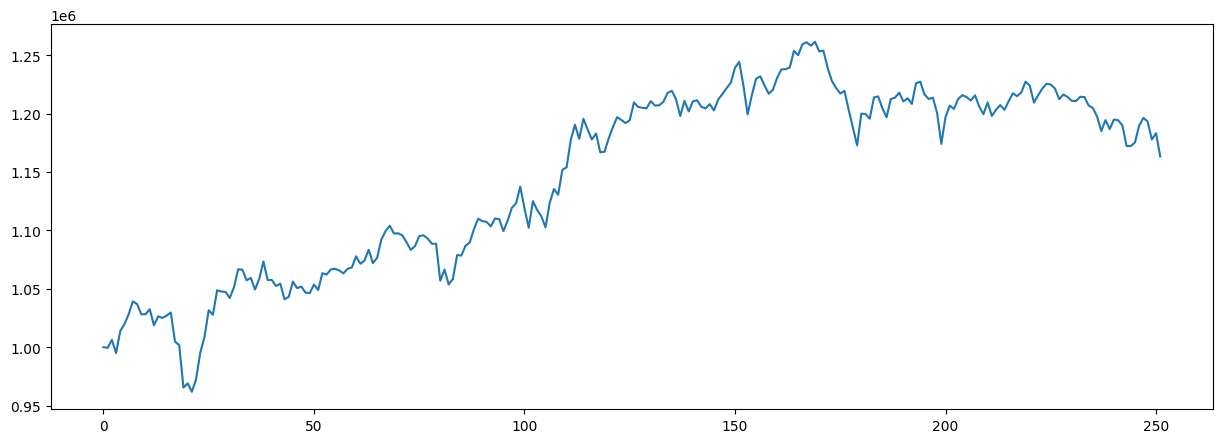

In [10]:
df_account_value.account_value.plot()

In [17]:
import pyfolio
import datetime
from copy import deepcopy
from pyfolio import timeseries

from helper_function import backtest_stats, get_baseline

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 10000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

Stock Dimension: 29, State Space: 291


In [13]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.163224
Cumulative returns     0.163224
Annual volatility      0.143522
Sharpe ratio           1.129530
Calmar ratio           2.096055
Stability              0.764828
Max drawdown          -0.077872
Omega ratio            1.207423
Sortino ratio          1.657294
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.102412
Daily value at risk   -0.017439
dtype: float64


In [14]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)
Annual return          0.237370
Cumulative returns     0.236325
Annual volatility      0.133856
Sharpe ratio           1.664932
Calmar ratio           2.930392
Stability              0.887390
Max drawdown          -0.081003
Omega ratio            1.324332
Sortino ratio          2.484791
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.118609
Daily value at risk   -0.015980
dtype: float64


In [19]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
display("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')

'df_dji: '

,date,dji
0,2020-10-01,1.000000e+07
1,2020-10-02,9.951796e+06
2,2020-10-05,1.011926e+07
3,2020-10-06,9.984132e+06
4,2020-10-07,1.017492e+07
...,...,...
247,2021-09-24,1.250966e+07
248,2021-09-27,1.253532e+07
249,2021-09-28,1.233063e+07
250,2021-09-29,1.236325e+07


'df_dji: '

,dji
date,
2020-10-01,1.000000e+07
2020-10-02,9.951796e+06
2020-10-05,1.011926e+07
2020-10-06,9.984132e+06
2020-10-07,1.017492e+07
...,...
2021-09-24,1.250966e+07
2021-09-27,1.253532e+07
2021-09-28,1.233063e+07
